<a href="https://colab.research.google.com/github/anshudaur/TensorFlowProjects/blob/master/ConvolutionNeuralNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
 %tensorflow_version 2.x  
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import models

import os
import tensorflow as tf
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt

tf.__version__


'2.2.0'

9
Ankle boot
Train data Shape:(60000, 28, 28)
Train labels Shape:(60000,)


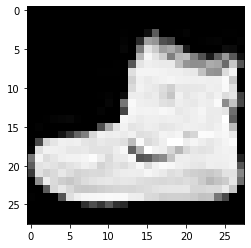

In [0]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
#labels
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] 

print(train_labels[0]) 
plt.imshow(train_images[0], cmap="Greys_r")
print(class_names[train_labels[0]])


data = tf.data.Dataset.from_tensor_slices(
    (train_images.reshape([-1, 28, 28, 1]).astype(np.float32) / 255, train_labels.astype(np.int32)))
data = data.shuffle(buffer_size=60000).batch(128).repeat()

# note: we batch the test data, but do not shuffle/repeat
test_data = tf.data.Dataset.from_tensor_slices(
    (test_images.reshape([-1, 28, 28, 1]).astype(np.float32) / 255, test_labels.astype(np.int32))).batch(128)

#Train data Shape:(60000, 28, 28)
print("Train data Shape:"+ str(train_images.shape))  
#Train labels Shape:(60000,)
print("Train labels Shape:"+ str(train_labels.shape)) 

MLP built with Keras layers

In [0]:
train_steps = 2500
input_shape = (28,28,1)

n_h = 256
layer_list = [tf.keras.layers.Flatten(input_shape=(28, 28)),      
              tf.keras.layers.Dense(n_h, activation=tf.nn.relu),
              tf.keras.layers.Dense(n_h//2, activation=tf.nn.relu),
              tf.keras.layers.Dense(10)]  
model = tf.keras.Sequential(layer_list)

opt = tf.optimizers.SGD(0.5)

# from_logits = True , neverforget . 
# y_pred encodes a probability distribution. 
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy()


In [0]:
def train(): 
  for step, (img_batch, lbl_batch) in enumerate(data):
      if step > train_steps:
          break

      # print("Image_batch shape:"+ str(img_batch.shape)+ " lbl_batch shape:"+ str(lbl_batch.shape))
      with tf.GradientTape() as tape:
         logits = model(img_batch)
        # loss : actual labels, predicted outputs
         xent = loss_fn(lbl_batch, logits)
      # Custom training loop with Gradient Tape
      # if you didn't build the model, it is important that you get the variables
      # AFTER the model has been called the first time
      varis = model.trainable_variables
      grads = tape.gradient(xent, varis)

      #zip(): returns an iterator of tuples with each tuple having elements from all the iterables.
      opt.apply_gradients(zip(grads, varis))
    
      metric(lbl_batch, logits)
    
      if not step % 100:
         # evaluate accuracy
         print("Step: {} Loss: {} Accuracy: {}".format(step, xent, metric.result()))
         metric.reset_states()

Evaluation magic : Automatically averages accuracies over test batches

In [0]:
def test(): 
  # here's some evaluation magic ;) bonus: figure out how this works...
  big_test_batch = next(iter(test_data))
  test_preds = tf.argmax(model(big_test_batch[0]), axis=1,
                        output_type=tf.int32)
  acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, big_test_batch[1]), tf.float32))
  print(acc)

SGD optimiser : 88% accuracy 

In [0]:
train()
test()

Step: 0 Loss: 2.2952253818511963 Accuracy: 0.125
Step: 100 Loss: 0.8788655996322632 Accuracy: 0.5531250238418579
Step: 200 Loss: 0.6812146902084351 Accuracy: 0.7507030963897705
Step: 300 Loss: 0.36435723304748535 Accuracy: 0.7810937762260437
Step: 400 Loss: 0.4566102623939514 Accuracy: 0.805468738079071
Step: 500 Loss: 0.5914007425308228 Accuracy: 0.8214285969734192
Step: 600 Loss: 0.3885219395160675 Accuracy: 0.8285156488418579
Step: 700 Loss: 0.3668566048145294 Accuracy: 0.8374999761581421
Step: 800 Loss: 0.4465700685977936 Accuracy: 0.8471093773841858
Step: 900 Loss: 0.4112775921821594 Accuracy: 0.8479687571525574
Step: 1000 Loss: 0.3329603672027588 Accuracy: 0.8484492301940918
Step: 1100 Loss: 0.33310750126838684 Accuracy: 0.8572656512260437
Step: 1200 Loss: 0.2726841866970062 Accuracy: 0.8609374761581421
Step: 1300 Loss: 0.5507745742797852 Accuracy: 0.8589843511581421
Step: 1400 Loss: 0.38468071818351746 Accuracy: 0.8596875071525574
Step: 1500 Loss: 0.40151453018188477 Accuracy: 0

Adam Optimizer: 89.8% test accuracy

Note : test and train has to be compiled again so that Adam doesn't continue training from the old model state which was traned with SGD

In [0]:
# Adam makes things much smoother
opt = tf.optimizers.Adam()
train()
test()

Step: 0 Loss: 0.3915899395942688 Accuracy: 0.84375
Step: 100 Loss: 0.32665306329727173 Accuracy: 0.8939062356948853
Step: 200 Loss: 0.23172621428966522 Accuracy: 0.8989062309265137
Step: 300 Loss: 0.3249376714229584 Accuracy: 0.8928906321525574
Step: 400 Loss: 0.17237824201583862 Accuracy: 0.8917187452316284
Step: 500 Loss: 0.19651998579502106 Accuracy: 0.8981829285621643
Step: 600 Loss: 0.22767943143844604 Accuracy: 0.8992968797683716
Step: 700 Loss: 0.27533087134361267 Accuracy: 0.8989062309265137
Step: 800 Loss: 0.2799614667892456 Accuracy: 0.9013281464576721
Step: 900 Loss: 0.24311433732509613 Accuracy: 0.9052343964576721
Step: 1000 Loss: 0.16753198206424713 Accuracy: 0.9044486284255981
Step: 1100 Loss: 0.22776232659816742 Accuracy: 0.904296875
Step: 1200 Loss: 0.3381388485431671 Accuracy: 0.9075000286102295
Step: 1300 Loss: 0.25784924626350403 Accuracy: 0.9007812738418579
Step: 1400 Loss: 0.4200458228588104 Accuracy: 0.9009374976158142
Step: 1500 Loss: 0.2233562022447586 Accuracy:

**CNN Implementation with Fashion MNIST**


**Same Convolution and Experimenting with different filter sizes**

Odd Filter Sizes
* Filter size (1X1) : 91.4% accuracy with 256-512-1024 filters in conv layers and increasing number of filters to 512-1024-2048 gave 85% accuracy
* Filter size (3X3) : 93% accuracy with 128-256-512 filters in conv layers
* Filter size (5X5) : 92% accuracy with 128-256-512 filters in conv layers
* Filter size (7X7) : 92.3% accuracy with 128-256-512 filters in conv layers
* Filter size (11X11) : 90.7% accuracy with 128-256-512 filters in conv layers and with 64-128-256 filters :86.7% accuracy 

Maximum Filter size
* Filter size (28X28) with max pooling: ResourceExhaustedError
* Filter size (28X28) with no max pooling: 85% accuracy - Fully connected network


Even filter sizes :
* Filter size (2X2) : 92.2% accuracy with 128-256-512 filters in conv layers
* Filter size (4X4) : 91.4% accuracy with 128-256-512 filters in conv layers
* Filter size (6X6) : 93% accuracy with 128-256-512 filters in conv layers
* Filter size (8X8) : 90.6% accuracy with 128-256-512 and 92.7% for 32-64-128 filters in conv layers

Notes : 
1.  Filter/kernel size:
* Bigger filter size - less number of filters: But for bigger kernel which are equivalent to image size, the model behaves like fully connected neural network  with equivalent performance, less weight sharing and hence taking more training time. 
* Smaller filter size - more filters : It makes sense to take into account local pixel information by taking small convolution filters.  We use the same kernel for different set of pixels in an image, the same weights are shared across these pixel sets as we convolve on them. And as the number of weights are less than a fully connected layer, we have lesser weights to back-propagate on. 

2. Even and Odd Filter/kernel : Here, even and odd filter perform equally better. But in general, odd filters are preferred. 

3. More number of filters improved test accuracy: more features are getting learned





In [0]:
def cnn_model2(input_shape):
  layer_list = [tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', input_shape = input_shape),
                tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1)),
                tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'),
                tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1)),
                tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'),
                tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1)),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(512, activation='relu'),
                tf.keras.layers.Dense(10)]  
  model = tf.keras.Sequential(layer_list)
  return model

input_shape = (28,28,1)

# Adam makes things much smoother
opt = tf.optimizers.Adam()
model = cnn_model2(input_shape)
model.summary()
train()
test()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 28, 28, 128)       6400      
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 27, 27, 128)       0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 27, 27, 256)       1605888   
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 26, 26, 256)       0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 26, 26, 512)       6423040   
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 25, 25, 512)       0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 320000)          

Valid convolution : convolution of filter is done entirely with the image without any zero padding, as result of which the output shrinks with each layer.
* 3X3 filter size, 128-256-512 filters: 89% test accuracy
* 5X5 , 32-64-128 : 93.75% test accuracy and 128-256-512 filters : 87.5% test accuracy
* 11X11 filter size: Invalid dimensions error


In [0]:
def cnn_model1(input_shape):
  layer_list = [tf.keras.layers.Conv2D(filters=128, kernel_size=(5,5), padding='valid', activation='relu', input_shape = input_shape),
                  tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'),
                  tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), padding='valid', activation='relu'),
                  tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'),
                  tf.keras.layers.Conv2D(filters=512, kernel_size=(5,5), padding='valid', activation='relu'),
                  tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'),
                  tf.keras.layers.Flatten(),
                  tf.keras.layers.Dense(512, activation='relu'),
                  tf.keras.layers.Dense(10)]  
  model = tf.keras.Sequential(layer_list)
  return model

# Adam makes things much smoother
opt = tf.optimizers.Adam()
input_shape = (28,28,1)
model = cnn_model1(input_shape)
model.summary()
train()
test()

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_168 (Conv2D)          (None, 24, 24, 128)       3328      
_________________________________________________________________
max_pooling2d_141 (MaxPoolin (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_169 (Conv2D)          (None, 19, 19, 256)       819456    
_________________________________________________________________
max_pooling2d_142 (MaxPoolin (None, 18, 18, 256)       0         
_________________________________________________________________
conv2d_170 (Conv2D)          (None, 14, 14, 512)       3277312   
_________________________________________________________________
max_pooling2d_143 (MaxPoolin (None, 13, 13, 512)       0         
_________________________________________________________________
flatten_56 (Flatten)         (None, 86528)           

**CIFAR10 with CNN**

170500096/170498071 [==============================] - 6s 0us/step


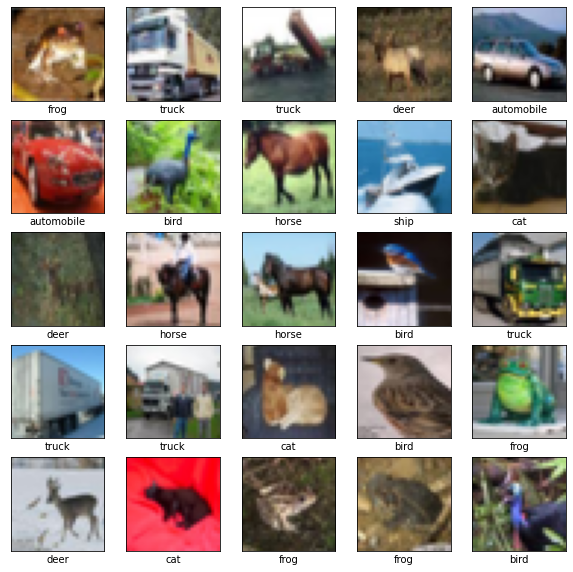

Train data :(50000, 32, 32, 3)
Train label :(50000, 1)


In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
# Normalize pixel values to be between 0 and 1
#train_images, test_images = train_images / 255.0, test_images / 255.0

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels are in the form of  arrays, which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

#Train data :(50000, 32, 32, 3)
print("Train data :"+ str(train_images.shape)) 

#Train label :(50000, 1)
print("Train label :"+ str(train_labels.shape))
data = tf.data.Dataset.from_tensor_slices(
    (train_images.reshape([-1, 32, 32, 3]).astype(np.float32) / 255, train_labels.reshape((-1,)).astype(np.int32)))
data = data.shuffle(buffer_size=50000).batch(128).repeat()

# note: we batch the test data, but do not shuffle/repeat
test_data = tf.data.Dataset.from_tensor_slices(
    (test_images.reshape([-1, 32, 32, 3]).astype(np.float32) / 255, test_labels.reshape((-1,)).astype(np.int32))).batch(128)


In [0]:
def plotLosses(history):  
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [0]:
train_steps = 2500
input_shape = (32,32,3)

In [0]:
def plotAccuracies(history):  
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='upper right')
    plt.show()

In [0]:
def run_model(model):
  model.summary()
  model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
  history = model.fit(train_images, train_labels, epochs=30, batch_size= 256, 
                    validation_data=(test_images, test_labels))
  
  plotLosses(history)
  plotAccuracies(history)

Model suffers from overfitting : 96% training accuracy and 73% test accuracy 

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_171 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_144 (MaxPoolin (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_172 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_145 (MaxPoolin (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_173 (Conv2D)          (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_146 (MaxPoolin (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_57 (Flatten)         (None, 2048)            

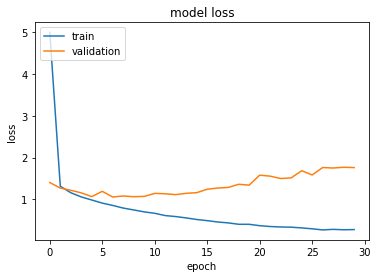

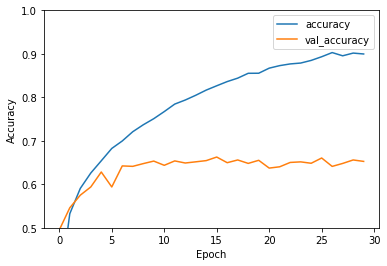

In [0]:
def cnn_cifar_model():
  layer_list = [tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape = input_shape),
                  tf.keras.layers.MaxPooling2D(2,2),
                  tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
                  tf.keras.layers.MaxPooling2D(2,2),
                  tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
                  tf.keras.layers.MaxPooling2D(2,2),
                  tf.keras.layers.Flatten(),
                  tf.keras.layers.Dense(64),
                  tf.keras.layers.Dense(10, activation= 'softmax')] 
  model = tf.keras.Sequential(layer_list)
  return model

  
model = cnn_cifar_model()
run_model(model)

Add more number of convolution layers and dropout to **reduce** **overfitting** : 81.5% training accuracy and 79% test accuracy

Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_174 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_175 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_147 (MaxPoolin (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_176 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_177 (Conv2D)          (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_148 (MaxPoolin (None, 8, 8, 64)        

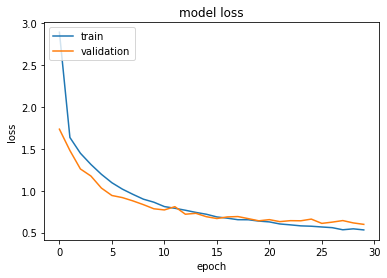

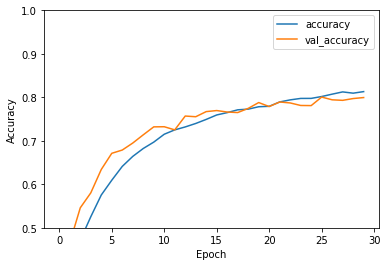

In [0]:
def cnn_cifar_model_1():
  layer_list = [tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape = input_shape),
                  tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
                  tf.keras.layers.MaxPooling2D(2,2),
                  tf.keras.layers.Dropout(0.25),
                  tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
                  tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
                  tf.keras.layers.MaxPooling2D(2,2),
                  tf.keras.layers.Dropout(0.25),
                  tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
                  tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
                  tf.keras.layers.MaxPooling2D(2,2),
                  tf.keras.layers.Dropout(0.25),
                  tf.keras.layers.Flatten(),
                  tf.keras.layers.Dense(512),
                  tf.keras.layers.Dropout(0.5),
                  tf.keras.layers.Dense(10, activation= 'softmax')] 
  model = tf.keras.Sequential(layer_list)
  return model

  
model = cnn_cifar_model_1()
run_model(model)

Adding Batch Normalization as another regularization technique : 86.4% training accuracy and 81.4% test accuracy

Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_180 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_181 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_150 (MaxPoolin (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_182 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_183 (Conv2D)          (None, 16, 16, 64)      

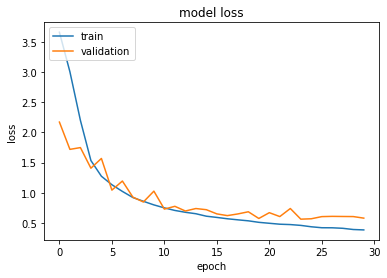

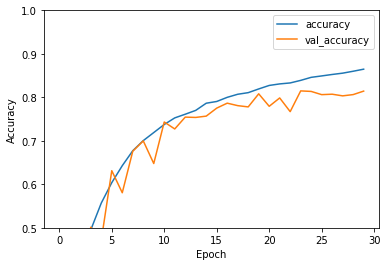

In [0]:
def cnn_cifar_model_2():
  layer_list = [tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape = input_shape),
                  tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
                  tf.keras.layers.BatchNormalization(),
                  tf.keras.layers.MaxPooling2D(2,2),
                  tf.keras.layers.Dropout(0.25),
                  tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
                  tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
                  tf.keras.layers.BatchNormalization(),
                  tf.keras.layers.MaxPooling2D(2,2),
                  tf.keras.layers.Dropout(0.25),
                  tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
                  tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
                  tf.keras.layers.BatchNormalization(),
                  tf.keras.layers.MaxPooling2D(2,2),
                  tf.keras.layers.Dropout(0.25),
                  tf.keras.layers.Flatten(),
                  tf.keras.layers.Dense(512),
                  tf.keras.layers.Dropout(0.5),
                  tf.keras.layers.Dense(10, activation= 'softmax')] 
  model = tf.keras.Sequential(layer_list)
  return model

  
model = cnn_cifar_model_2()
run_model(model)

Weights Initializer : he_uniform  : 95% training accuracy and 85% test accuracy for 30 epochs

*References : https://towardsdatascience.com/hyper-parameters-in-action-part-ii-weight-initializers-35aee1a28404

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       1

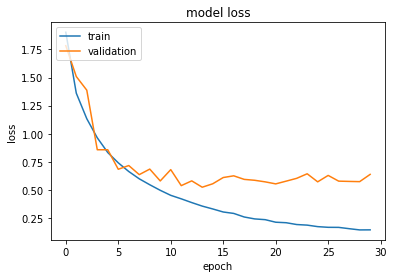

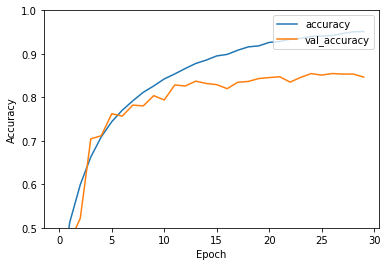

In [0]:
def cnn_cifar_model_3():
  layer_list = [tf.keras.layers.BatchNormalization(input_shape = input_shape),
                tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3),kernel_initializer='he_uniform', padding='same', activation='relu'),
                  tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='he_uniform',padding='same', activation='relu'),                    
                  tf.keras.layers.MaxPooling2D(2,2),
                  tf.keras.layers.Dropout(0.25),     
                  tf.keras.layers.BatchNormalization(),           
                  tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3),kernel_initializer='he_uniform', padding='same', activation='relu'),
                  tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3),kernel_initializer='he_uniform', padding='same', activation='relu'),                   
                  tf.keras.layers.MaxPooling2D(2,2),
                  tf.keras.layers.Dropout(0.25), 
                  tf.keras.layers.BatchNormalization(),                
                  tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3),kernel_initializer='he_uniform', padding='same', activation='relu'),
                  tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3),kernel_initializer='he_uniform', padding='same', activation='relu'),
                  tf.keras.layers.MaxPooling2D(2,2),
                  tf.keras.layers.Dropout(0.25),                 
                  tf.keras.layers.Flatten(),
                  tf.keras.layers.Dense(512,kernel_initializer='he_uniform', activation='relu'),
                  tf.keras.layers.Dropout(0.5),
                  tf.keras.layers.Dense(10, activation= 'softmax')] 
  model = tf.keras.Sequential(layer_list)
  return model

  
model = cnn_cifar_model_3()
run_model(model)

Adding more layers does not always give better performance. Although accuracy improves, but overfitting also increases because of vanishing gradients. 

Resnet Implementation : 98% training accuracy and  91.5% test accuracy 

Resnet use skip connection or identity mapping, this identity mapping does not have any parameters and is just there to add the output from the previous layer to the layer ahead.  It provides a clear path for gradients to back propagate to early layers of the network avoiding vanishing gradient problem.


In [9]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

# Training parameters
batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 200
data_augmentation = True
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


model = resnet_v2(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

print('Using real-time data augmentation.')
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    # set input mean to 0 over the dataset
    featurewise_center=False,
    # set each sample mean to 0
    samplewise_center=False,
    # divide inputs by std of dataset
    featurewise_std_normalization=False,
    # divide each input by its std
    samplewise_std_normalization=False,
    # apply ZCA whitening
    zca_whitening=False,
    # epsilon for ZCA whitening
    zca_epsilon=1e-06,
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=0,
    # randomly shift images horizontally
    width_shift_range=0.1,
    # randomly shift images vertically
    height_shift_range=0.1,
    # set range for random shear
    shear_range=0.,
    # set range for random zoom
    zoom_range=0.,
    # set range for random channel shifts
    channel_shift_range=0.,
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    # value used for fill_mode = "constant"
    cval=0.,
    # randomly flip images
    horizontal_flip=True,
    # randomly flip images
    vertical_flip=False,
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)

# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

# Fit the model on the batches generated by datagen.flow().
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    validation_data=(x_test, y_test),
                    epochs=epochs, verbose=1, workers=4,
                    callbacks=callbacks)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Using TensorFlow backend.


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)
Learning rate:  0.001
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


391/391 [==============================] - 32s 82ms/step - loss: 1.4252 - accuracy: 0.6111 - val_loss: 1.9774 - val_accuracy: 0.4748
Epoch 3/200
Learning rate:  0.001
391/391 [==============================] - 32s 82ms/step - loss: 1.2488 - accuracy: 0.6641 - val_loss: 1.3262 - val_accuracy: 0.6422
Epoch 4/200
Learning rate:  0.001
391/391 [==============================] - 32s 82ms/step - loss: 1.1162 - accuracy: 0.7054 - val_loss: 1.1828 - val_accuracy: 0.6819
Epoch 5/200
Learning rate:  0.001
391/391 [==============================] - 32s 82ms/step - loss: 1.0211 - accuracy: 0.7387 - val_loss: 1.7081 - val_accuracy: 0.5742
Epoch 6/200
Learning rate:  0.001
391/391 [==============================] - 32s 82ms/step - loss: 0.9527 - accuracy: 0.7597 - val_loss: 1.3968 - val_accuracy: 0.6251
Epoch 7/200
Learning rate:  0.001
391/391 [==============================] - 32s 82ms/step - loss: 0.9015 - accuracy: 0.7761 - val_loss: 0.9561 - val_accuracy: 0.7556
Epoch 8/200
Learning rate:  0.00

Visualization of Resnet results

In [0]:
def visualize(img):
  plt.imshow(img, cmap=plt.cm.binary)
  img = img_to_array(img)
  img = expand_dims(img, axis=0)
  print(img.shape)

  layer_outputs = [layer.output for layer in model.layers[:11]] 
  # Extracts the outputs of the top 12 layers
  # Creates object of trained model that will return outputs of every layer given the model input
  activation_model = models.Model(inputs=model.input, outputs=layer_outputs) 
  activations = activation_model.predict(img) 

  layer_names = []
  for layer in model.layers:
    layer_name=layer.name
    #print(layer_name)
    #if(layer_name.find("conv2d")):
    layer_names.append(layer_name)
    
  images_per_row = 8
  for layer_name, layer_activation in zip(layer_names, activations): 
      n_features = layer_activation.shape[-1] 
      
      #print(n_features)
      size = layer_activation.shape[1] # (1, size, size, n_features).
      n_cols = n_features // images_per_row 
      display_grid = np.zeros((size * n_cols, images_per_row * size))
      for col in range(n_cols): 
          for row in range(images_per_row):
              channel_image = layer_activation[0,:, :,col * images_per_row + row]
              display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
      plt.figure(figsize=(16,16))
      plt.title(layer_name)
      plt.grid(False)

      plt.grid(False)
      plt.imshow(display_grid, cmap='jet') #heatmaps


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.


(1, 32, 32, 3)


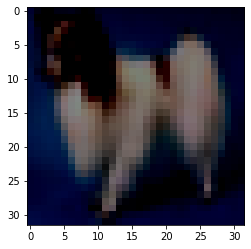

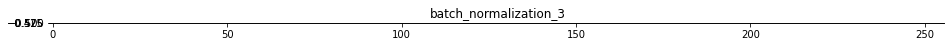

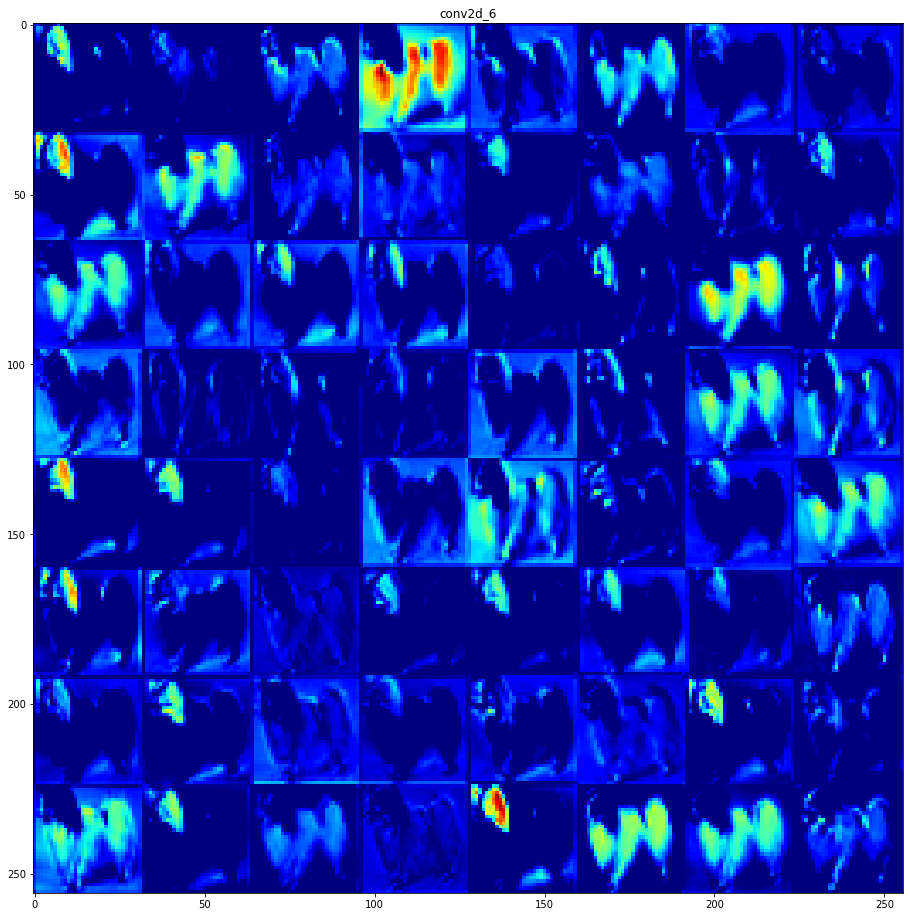

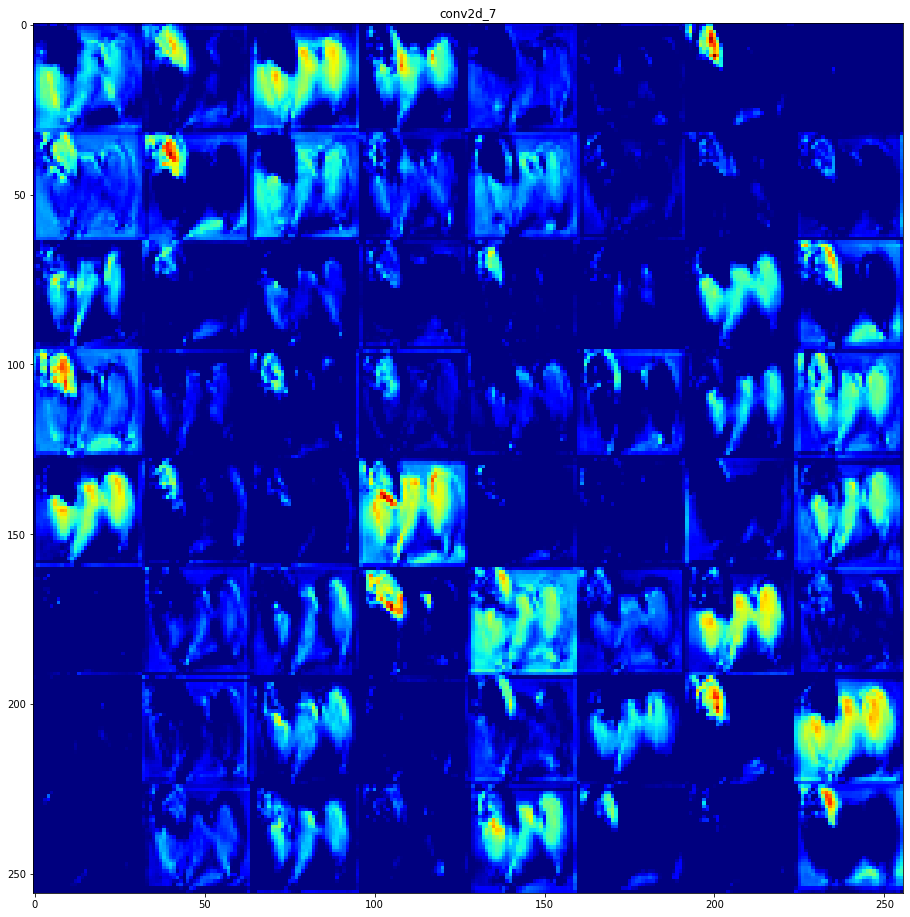

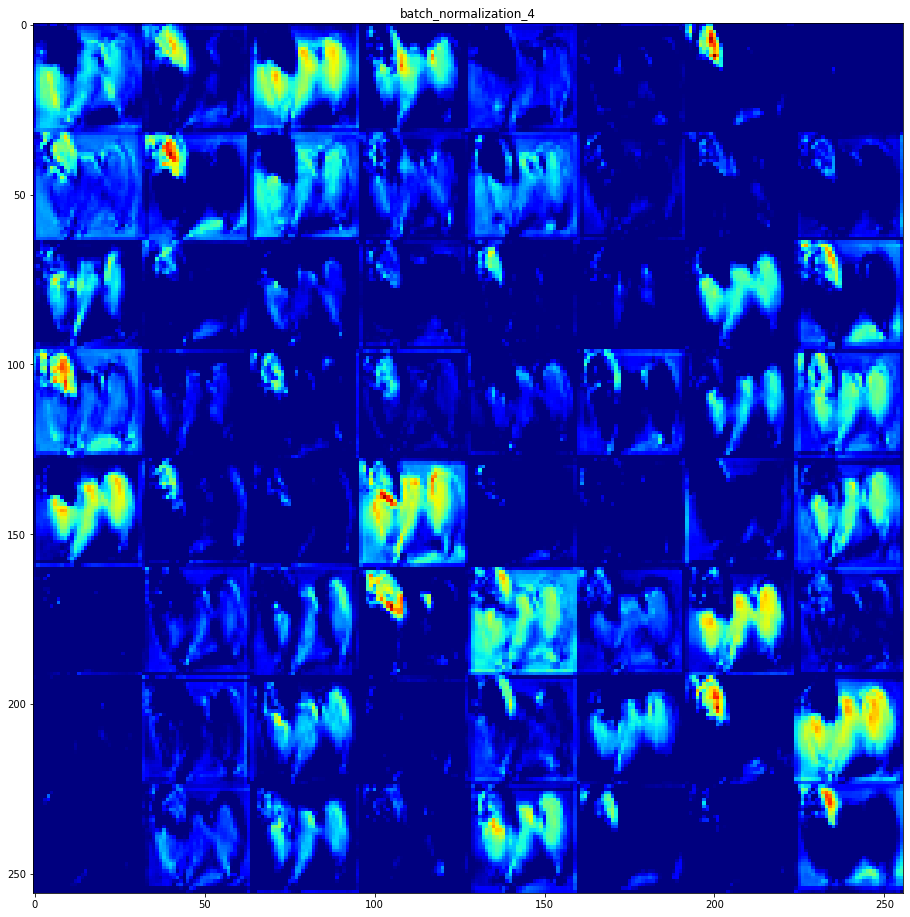

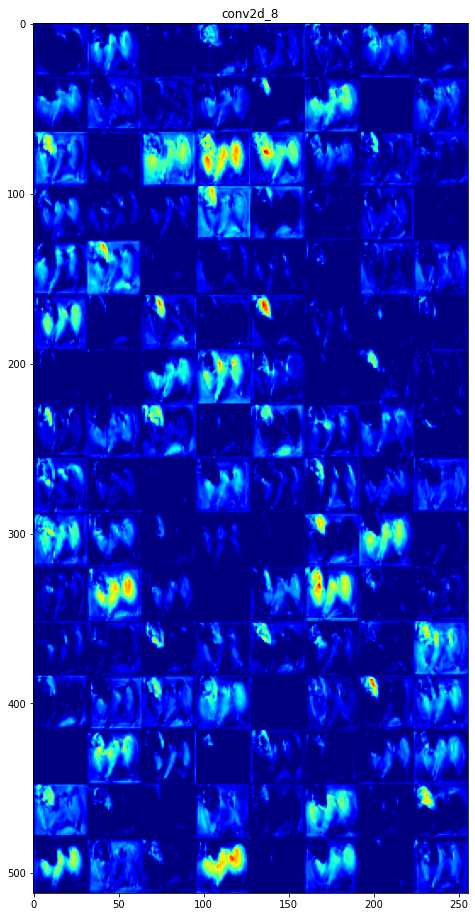

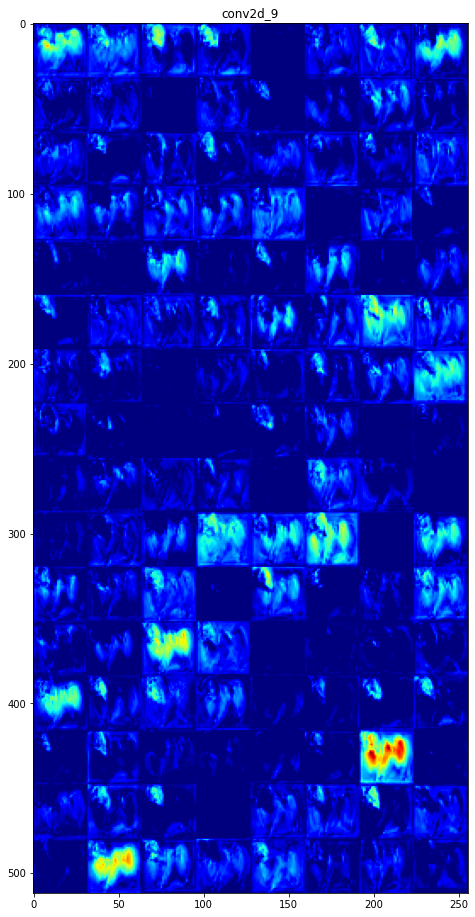

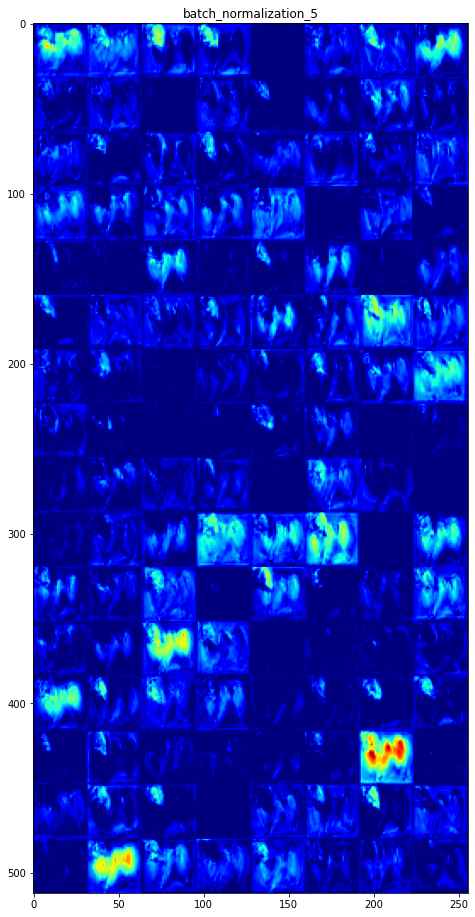

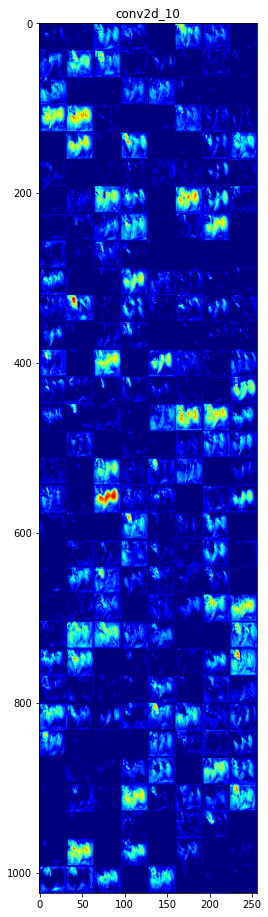

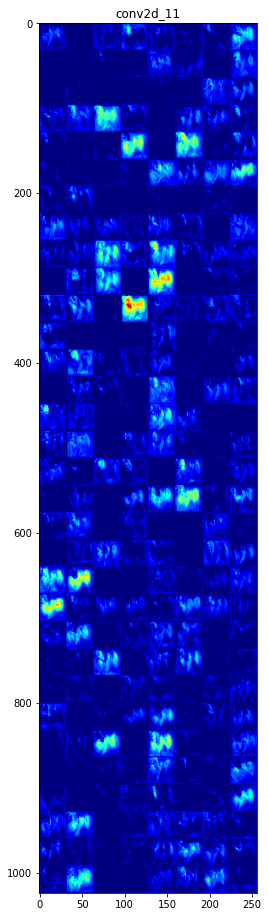

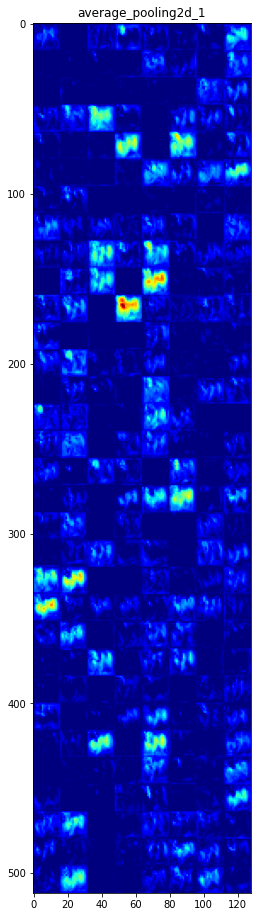

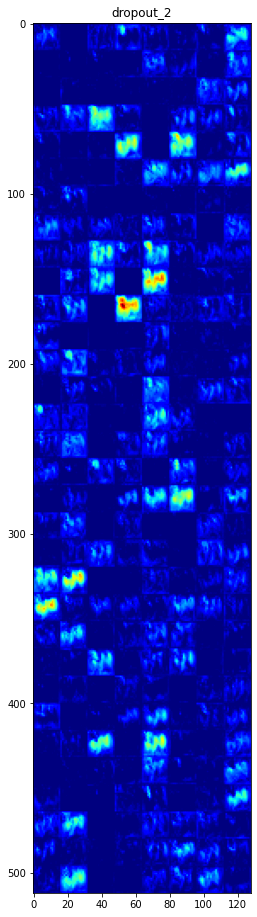

In [0]:
visualize(x_train[4000])
